<a href="https://colab.research.google.com/github/Kiritiaajd/CIFAR10/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Load The Data


In [3]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
#  Number of Subprocesses to use for data loading
num_working = 0
# How many samples per torch to load
batch_size = 20
# Percentage of training set to use as validation
valid_size = 0.2

# Convert data to normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10('data' , train = True , download = True , transform = transform)
test_data = datasets.CIFAR10('data' , train = False , download = True , transform  = transform)
# Obtain training indices that will be used fro validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx , valid_idx = indices[split:] , indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler )
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_working) # Changed 'num_working' to 'num_workers'
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_working) # Changed 'num_working' to 'num_workers'
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_working) # Changed 'num_working' to 'num_workers'

# Specify the image classes
classes = ['airplane' , 'automobile' , 'bird' , 'cat' , 'deer' ,
           'dog' , 'frog'  , 'horse' , 'ship' , 'truck']


100%|██████████| 170498071/170498071 [00:04<00:00, 42419613.20it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


*Visualize a Batch of Training Data*

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# helper function to un-normalize and Display an image
def imshow(img):
    img  = img/2 +0.5
    plt.imshow(np.transpose(img ,(1,2,0)))


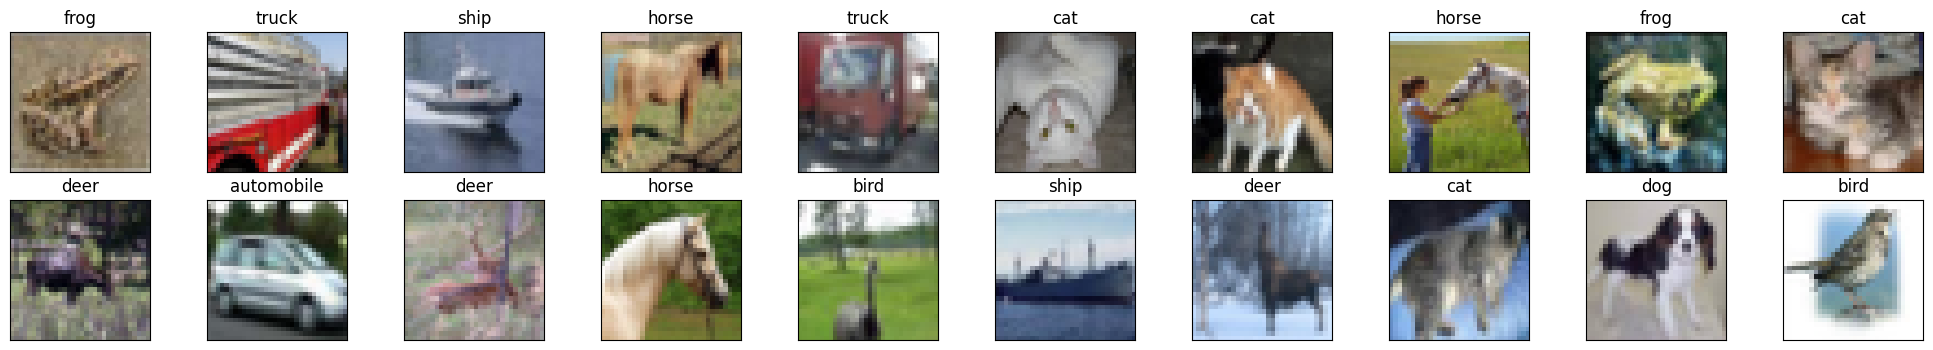

In [6]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# Plot the images in the batch along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
   ax = fig.add_subplot(2, 10, idx+1)  # Changed 20/2 to 10
   imshow(images[idx])
   ax.set_title(classes[labels[idx]])
   ax.set_xticks([])  # Set xticks to empty list
   ax.set_yticks([])  # Set yticks to empty list
plt.show()

View an Image in More Detail
Here we look at the normalized red green and blue (RGB) color channels as three seperate , grayscale intensity images


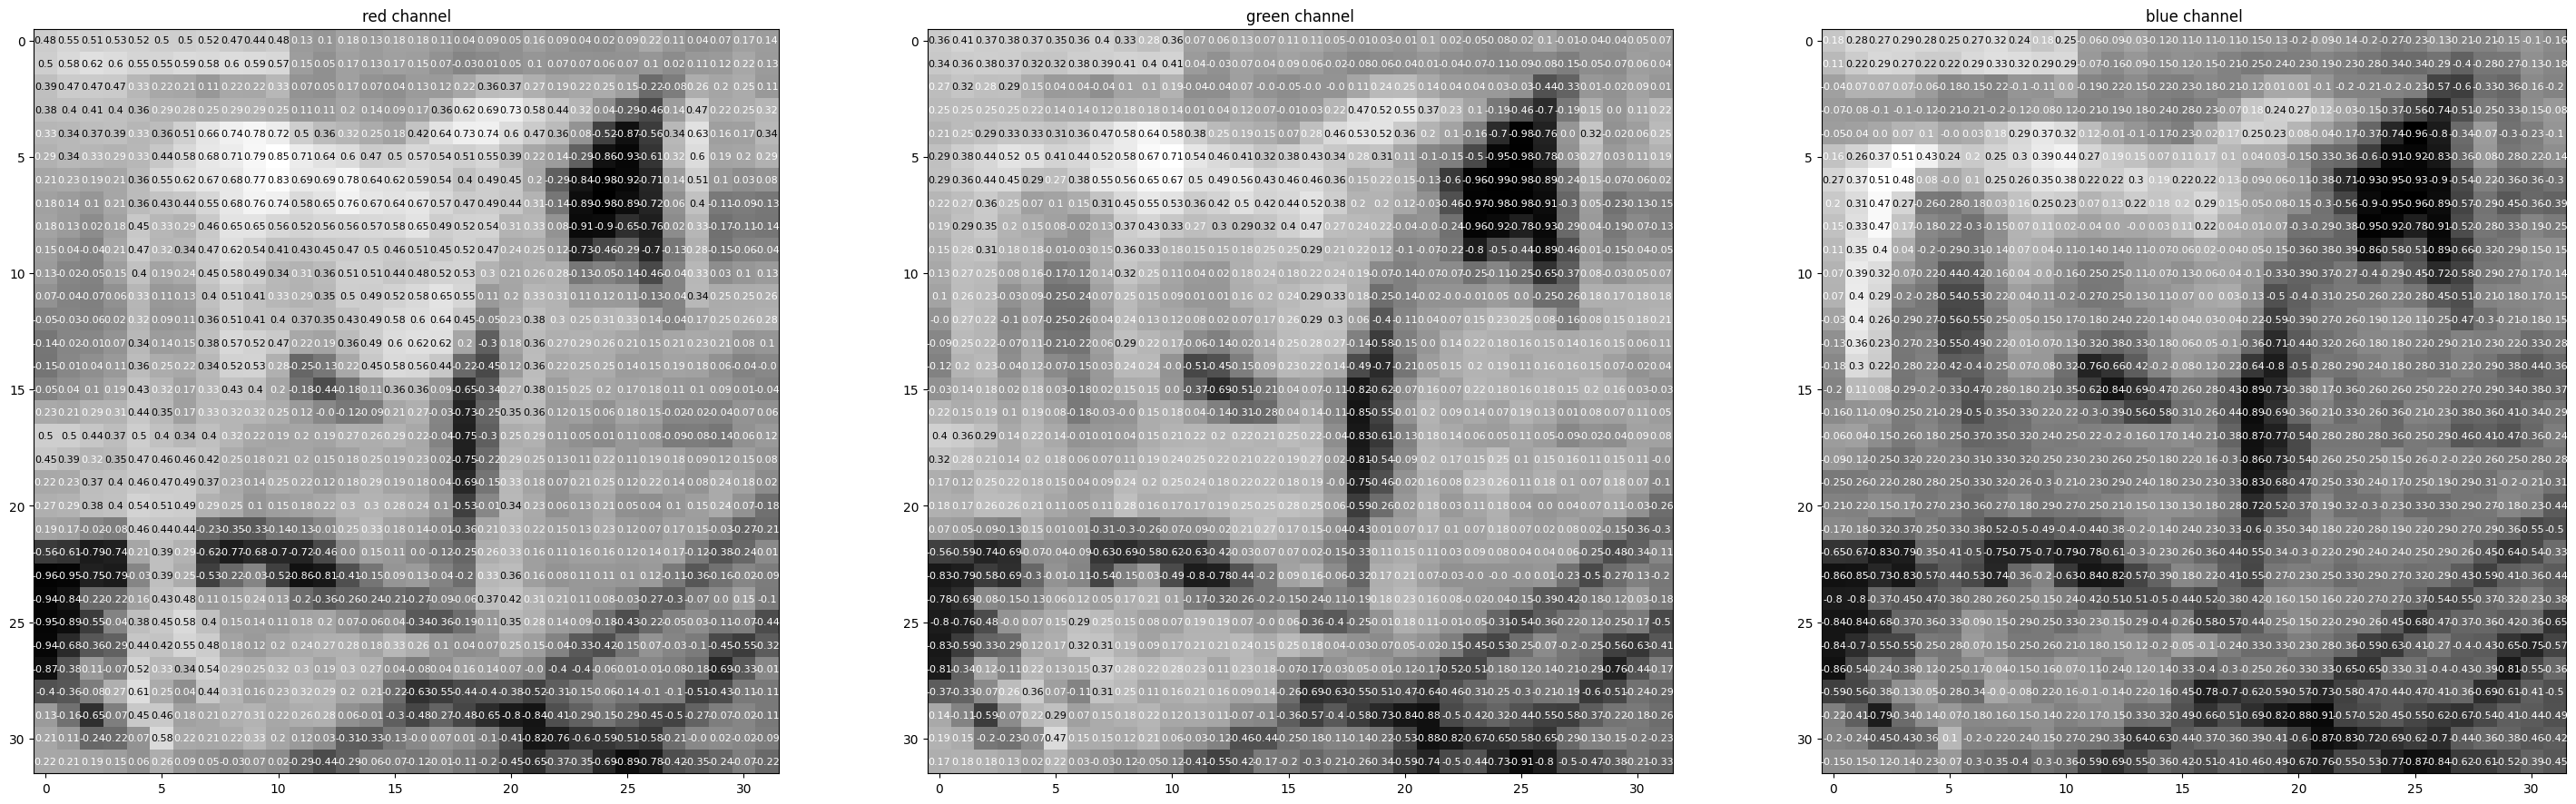

In [7]:
rgb_img = np.squeeze(images[3])
channels = ['red channel' , 'green channel' , 'blue channel']

fig = plt.figure(figsize = (36 , 36))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1 , 3 , idx + 1)
  img = rgb_img[idx]
  ax.imshow(img , cmap ='gray')
  ax.set_title(channels[idx])
  width , height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
    for y in range(height):
        val = round(img[x][y] , 2 ) if img[x][y] != 0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')
plt.show()

**Define the networks Architecture **

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #  Convolutional Layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # Max Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layer
        self.fc1 = nn.Linear(64 * 4 * 4, 500)

        #  Dropout
        self.dropout = nn.Dropout(0.2)

        #   Output layer
        self.out = nn.LogSoftmax(dim=1)

    def flatten(self, x):
        return x.view(x.size(0), -1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

#  create a complete CNN
model = Net()
print(model)

# move tensor to GPU if cuda is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out): LogSoftmax(dim=1)
)


In [9]:
from torchsummary import summary

summary(model, input_size = images.shape[1:], batch_size = 20)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [20, 16, 32, 32]             448
         MaxPool2d-2           [20, 16, 16, 16]               0
            Conv2d-3           [20, 32, 16, 16]           4,640
         MaxPool2d-4             [20, 32, 8, 8]               0
            Conv2d-5             [20, 64, 8, 8]          18,496
         MaxPool2d-6             [20, 64, 4, 4]               0
            Linear-7                  [20, 500]         512,500
           Dropout-8                  [20, 500]               0
        LogSoftmax-9                  [20, 500]               0
Total params: 536,084
Trainable params: 536,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.23
Forward/backward pass size (MB): 5.70
Params size (MB): 2.04
Estimated Total Size (MB): 7.98
-------------------------------------------

**Specify Loss Function and Optimizer :**

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; this PyTorch classification example or this, more complex Keras example. Pay close attention to the value for learning rate as this value determines how your model converges to a small error.

In [10]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


Train The Network


In [11]:
import numpy as np
n_epochs = 10
epochs_no_improve=0
max_epochs_stop=3

save_file_name = 'model-cifar.pt'
valid_loss_min = np.Inf # track change in validation
def train(model, train_loader, valid_loader,
          n_epochs = 20, save_file = 'model-cifar.pt'):

    # specify loss function
    criterion = nn.NLLLoss()

    # specify optimizer
    optimizer = optim.Adam(model.parameters())

    epochs_no_improve = 0
    max_epochs_stop = 5
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0
  #  Train the model
    model.train()

for ii , (data , target) in enumerate(train_loader):
    if train_on_gpu:
        data , target = data.cuda() , target.cuda()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output , target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    # calculate accuracy
    ps = torch.exp(output)
    topk , topclass = ps.topk(1 , dim = 1)
    equals = topclass == target.view(*topclass.shape)
    accuracy = torch.mean(equals.type(torch.FloatTensor))
    train_acc += accuracy.item()

       # print training/validation statistics
print('\nEpoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

print(f'Epoch: {epoch} \t {100 * ii / len(train_loader):.2f}% complete.', end = '\r')




Epoch: 10 	Training Loss: 9972.150102 	Validation Loss: 0.000000
